In [79]:
import os
import re
import numpy as np
import numpy
genecode_genes = set(os.listdir("experiment_blood"))
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
import random
import bisect
import math
import json
import sys
from __future__ import print_function

In [80]:
def in_ipynb():
    try:
        get_ipython()
        return True
    except NameError:
        return False

In [81]:
if in_ipynb():
    from matplotlib import pyplot as plt

In [82]:
# Should be at least 10**4, preferably 10**6
r2_simulation_size = 10**6

In [83]:
print("Please use like this: `predictions.py <tissue> <genes> <simulation_runs> <top_k_genes> <PLSR_dimensions>`\n"\
      "tissue can be any of: blood, muscle.\n"\
      "genes can be any of: TNNI1, batra, nakamori, all\n"\
      "simulation runs can be 10\n"\
      "top_k_genes can be 500\n"\
      "PLSR_dimensions can be 2"
     )
if not in_ipynb():
    tissue_arg = sys.argv[1]
    print("tissue: {}".format(tissue_arg))
    gene_arg = sys.argv[2]
    print("gene: {}".format(gene_arg))
    simulation_arg = int(sys.argv[3])
    print("simulation_arg: {}".format(simulation_arg))
    top_genes_arg = int(sys.argv[4])
    print("top_genes_arg: {}".format(top_genes_arg))
    PLSR_arg = int(sys.argv[5])
    print("PLSR_arg: {}".format(PLSR_arg))

Please use like this: `predictions.py <tissue> <genes> <simulation_runs> <top_k_genes> <PLSR_dimensions>`
tissue can be any of: blood, muscle.
genes can be any of: TNNI1, batra, nakamori, all
simulation runs can be 10
top_k_genes can be 500
PLSR_dimensions can be 2


In [84]:
def load_genes(filename):
    genes = set()
    repeated = set()
    with open(filename) as f:
        for line in f:
            line = line.rstrip()
            if line in genes:
                repeated.add(line)
            genes.add(line)
    failed = genes.difference(genecode_genes)
    if repeated:
        print("These genes appear more than once: {}".format([g for g in repeated]))
    if failed:
        print("Couldn't identify the following genes: {}".format([g for g in failed]))
    return genes.intersection(genecode_genes)

In [85]:
nakamori_genes = load_genes("nakamori_genes.txt")

These genes appear more than once: ['DMD', 'LDB3']
Couldn't identify the following genes: ['OHKA1', 'OPA']


In [86]:
len(nakamori_genes)

37

In [87]:
for gene in nakamori_genes:
    print(gene, end=" ")

ATP2A2 CAMK2B NRAP RYR1 DMD IMPDH2 BIN1 DTNA CAPZB VPS39 TBC1D15 VEGFA PDLIM3 ALPK3 FHOD1 CLCN1 ANK2 ATP2A1 GFPT1 CACNA1S PHKA1 LDB3 KIF13A NFIX MLF1 INSR ARFGAP2 MBNL2 USP25 TTN ABLIM2 COPZ2 UBE2D3 CAPN3 TXNL4A MBNL1 SOS1 

In [88]:
# Genes from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4224598/
batra_genes = load_genes("batra_genes.txt")

These genes appear more than once: ['TTYH3', 'CEBPA', 'LDB3', 'MEF2B', 'MST150', 'NDUFB10', 'PCM1', 'SNX1', 'IDH3A', 'TNNI1', 'TPM1', 'TPM3', 'CHRNA1', 'PDLIM5', 'DNAJB6', 'ASPH', 'TPM2']
Couldn't identify the following genes: ['SR140', 'ADFP', 'CUGBP1', 'MST150', 'DNAPTP6']


In [89]:
len(batra_genes)

75

In [90]:
for batra_gene in batra_genes:
    print(batra_gene, end=" ")

KCNK7 SPTB CEBPA LAMP2 PCM1 TNNI1 PIK3C2B EZR RIN1 SNX1 OSBPL1A MDN1 FASTK ABCA1 CACNB1 CIRBP KRBA1 ILF3 MYH6 CLDND1 PDLIM2 AP1G1 KDELR1 PCMT1 NUP43 IDH3A ALG3 TMEM38B CHRNA1 PEBP4 PCBD2 RAB24 TGFBI SPEG BRSK2 SLC25A36 MORC3 MEF2B LDB3 NR2F1 DST CDC42 NDUFB10 RTN2 MGP ARHGEF7 TBL2 TPM1 BRWD1 ATP5E MEF2D DES TPM3 AMHR2 TTYH3 MTCH1 MBNL2 GPS1 PFKFB2 SETD3 TJP2 CACNA1G KIF1B DAPK2 PDLIM5 DVL3 LMNA DNAJB6 AGL HDAC11 MEF2C SAMD4A ASPH COPS4 TPM2 

In [91]:
class Metadata:
    def __init__(self, ids, cels, metadata):
        self.IDs = ids
        self.CELs = cels
        self.modal_allele = [int(metadata[i]["modal_allele"]) for i in ids]
        self.progenitor_allele = [int(metadata[i]["progenitor_allele"]) for i in ids]
        self.MIRS = [int(metadata[i]["MIRS"]) for i in ids]
    def __str__(self):
        return "Metadata={{IDs: {}...,\n CELs: {}...,\n modal_allele: {}...,\n progenitor_allele: {}...,\n MIRS: {}...}}".format(self.IDs[:5], self.CELs[:5], self.modal_allele[:5], self.progenitor_allele[:5], self.MIRS[:5])
    def __repr__(self):
        return self.__str__()

def load_metadata():
    metadata = {}
    metadata_order = []
    with open("metadata.txt") as f:
        for i, line in enumerate(f):
            line = line.strip().split()
            if i == 0:
                names = line[1:]
            else:
                values = line[1:]
                patient_id = line[0]
                metadata_order.append(patient_id)
                metadata[patient_id] = {k: v for k, v in zip(names, values)}
    blood_IDs = [i for i in metadata_order]
    muscle_IDs = [i for i in metadata_order if metadata[i]["muscle_cel"] != "refused_biopsy"]
    blood_CELs = [metadata[i]["blood_cel"] for i in blood_IDs]
    muscle_CELs = [metadata[i]["muscle_cel"] for i in muscle_IDs]
        
    blood_record = Metadata(blood_IDs, blood_CELs, metadata)
    muscle_record = Metadata(muscle_IDs, muscle_CELs, metadata)
    return blood_record, muscle_record

In [92]:
blood_meta, muscle_meta = load_metadata()

In [93]:
def produce_data(meta, gene_names, experiment):
    IDs = meta.IDs
    probe_data = []
    probe_IDs = []
    for gene in gene_names:
        with open(os.path.join(experiment, gene)) as f:
            for i, line in enumerate(f):
                line = line.rstrip().split()
                if i == 0:
                    prefix = "patient_"
                    our_IDs = [elem[len(prefix):] for elem in line if re.match(prefix, elem)]
                    assert IDs == our_IDs
                    headers = {header: i for i, header in enumerate(line)}
                    patient_data = {header[len(prefix):]: i for i, header in enumerate(line) if re.match(prefix, header)}
                    def write_signature(line):
                        signature = []
                        for elem in ["gene_name", "probeset_id", "seq5to3plus", "chrom", "strand", "genocode_left", "genecode_right"]:
                            signature.append(line[headers[elem]])
                        return "_".join(signature)
                else:
                    probe_ID = write_signature(line)
                    rv = []
                    for patient_id in IDs:
                        rv.append(float(line[patient_data[patient_id]]))
                    probe_data.append(rv)
                    probe_IDs.append(probe_ID)
    probe_data = numpy.array(probe_data)
    return probe_data, probe_IDs

In [94]:
def choose_top_genes(indicies, data):
    """
    Take `indicies`, which is a list of ordered pairs
    `r2, column_index`, and a matrix of probeset data,
    `data`, and filter all rows to contain only genes on
    the `indicies` list.
    """
    just_indices = [i[1] for i in indicies]
    return data[just_indices, :]

def order_indicies(allele, data):
    """
    Return a sorted list of correlated genes, from the most to the least
    correlated. Each entry in the list is a tuple `r2, gene_index`, where
    `r2` denotes the correlation of gene expression and `allele`, and
    the index of the gene in the `data` matrix respectively.
    
    `allele` is the list of repeat lengths, with each repeat length
    corresponding to one column in `data`
    """
    r2s = []
    for i in range(data.shape[0]):
        gene_r, _ = pearsonr(allele, data[i])
        # We have to store both the gene and the gene index, to recover the indices after sorting.
        r2s.append((gene_r ** 2, i))
    r2s.sort()
    # This reverses the list, assuring decreasing order.
    r2s = r2s[::-1]
    return r2s

def choose_training_indicies(data, no_training_samples):
    """Return a partition of column indicies of the `data`
    matrix into two sets: `training_indicies, testing_indicies`.
    The training set will contain `no_training_samples` biological
    samples.
    """
    indices = list(range(data.shape[1]))
    random.shuffle(indices)
    training_indices = indices[:no_training_samples]
    test_indicies = indices[no_training_samples:]
    return training_indices, test_indicies

def split_data(data, training_indices, test_indices):
    """Return a partition of data into `training_set, testing_set`
    using an existing partition of column incidices into
    `training_indicies` and `test_indicies`
    """
    return data[:, training_indices], data[:, test_indices]

def cv(lista):
    return np.matrix(lista).transpose()
def rv(lista):
    return np.matrix(lista)

In [95]:
def filter_extremes(value, lowermost, uppermost):
    """If a value is lower or higher than lowermost or uppermost, return lowermost or uppermost. Otherwise, return value.
    """
    if value < lowermost:
        return lowermost
    if value > uppermost:
        return uppermost
    return value

In [96]:
def simulation_step(probeset_data, metadata, training_size, no_probes, n_components):
    """Execute a full step of the simulation, and return a tuple consisting of two lists:
    predicted repeat lengths, and the ground truth repeat lengths
    """
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [metadata.modal_allele[i] for i in training_i]
    repeat_length_testing = [metadata.modal_allele[i] for i in testing_i]
    
    top_genes = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    plsr = PLSRegression(n_components=n_components)
    
    plsr.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = plsr.predict(testing_set.transpose())
    results = [filter_extremes(i[0], min(repeat_length_training), max(repeat_length_training)) for i in results]

    return repeat_length_testing, results

In [97]:
assert filter_extremes(0, 10, 20) == 10
assert filter_extremes(15, 10, 20) == 15
assert filter_extremes(25, 10, 20) == 20

In [98]:
metadata = {"muscle": muscle_meta, "blood": blood_meta}

In [99]:
data = {"muscle": {}, "blood": {}}
annot = {"muscle": {}, "blood": {}}

In [100]:
def load_data(name, genes, muscle_or_blood):
    meta = metadata[muscle_or_blood]
    path = "experiment_" + muscle_or_blood
    d, a = produce_data(meta, genes, path)
    data[muscle_or_blood][name] = d
    annot[muscle_or_blood][name] = a

In [101]:
gene_sets = {"nakamori": nakamori_genes, "batra": batra_genes, "TNNI1": ["TNNI1"], "all": genecode_genes}

In [102]:
gene_sets

{'TNNI1': ['TNNI1'],
 'all': {'GAGE10',
  'COX16',
  'C7orf55-LUC7L2',
  'POLR1E',
  'SMIM20',
  'ZNF630',
  'RAB33A',
  'ZSWIM8',
  'CDC42EP4',
  'NFYC',
  'SLC1A2',
  'CDC42SE1',
  'AFM',
  'SEZ6L2',
  'NOM1',
  'PNPLA6',
  'DTWD1',
  'RP11-286N22.8',
  'SSSCA1',
  'CRACR2B',
  'RUSC2',
  'NDUFAF8',
  'TRIM55',
  'PSMD1',
  'RP11-80H18.3',
  'FGL2',
  'NSMCE3',
  'OR6M1',
  'PRELID2',
  'JMJD6',
  'TM2D3',
  'AC012414.1',
  'STK19',
  'POTEC',
  'N4BP1',
  'LEMD2',
  'ATP6V0E2',
  'GLIPR1L1',
  'SMYD5',
  'POU5F1',
  'GIMAP1-GIMAP5',
  'GPR171',
  'LHX4',
  'IRAK1BP1',
  'C22orf23',
  'CHPF2',
  'CAPS',
  'TRMU',
  'PRLR',
  'GOLGA6L4',
  'IQCE',
  'ZNF112',
  'NPC1',
  'SLIT3',
  'SMC1A',
  'GJA5',
  'GRINA',
  'CISD3',
  'SST',
  'ETHE1',
  'ATG101',
  'KANK3',
  'THAP1',
  'DIS3L2',
  'ABLIM3',
  'PRSS41',
  'SVEP1',
  'WDR63',
  'CHCHD2',
  'FMR1',
  'COX8C',
  'APOOL',
  'CWH43',
  'CBWD1',
  'S100A10',
  'TRMT1L',
  'ITGA11',
  'MCHR1',
  'DPP4',
  'SEPT4',
  'RALGPS2',
  'CEP7

In [103]:
for name, genes in gene_sets.items():
    for tissue in ["blood", "muscle"]:
        load_data(name, genes, tissue)

In [104]:
data

{'blood': {'TNNI1': array([[4.87580447, 4.82371186, 4.55055525, ..., 4.64524442, 4.43048736,
          4.82956405],
         [3.80875057, 4.20825844, 4.45427485, ..., 4.08672937, 3.90090915,
          3.83550951],
         [5.68987335, 5.37966317, 5.83730864, ..., 5.34247995, 5.30714683,
          5.54664578],
         ...,
         [4.81623794, 4.81828238, 4.58953808, ..., 5.15047517, 4.35084812,
          4.83804904],
         [7.79403259, 6.97475194, 7.42857611, ..., 7.33565746, 7.22548473,
          7.60858667],
         [4.52945037, 4.09812824, 4.26518947, ..., 5.0200101 , 4.68643356,
          4.26685673]]),
  'all': array([[6.19894043, 6.48280705, 5.80069432, ..., 6.48477294, 6.12451753,
          6.25587144],
         [5.78972222, 5.74474944, 5.46227218, ..., 5.63553568, 5.87952672,
          5.63643369],
         [6.04850693, 5.97422277, 5.7194074 , ..., 5.91755038, 6.11407835,
          5.77869842],
         ...,
         [4.20264046, 4.31463025, 4.69176639, ..., 4.1235151 , 

In [105]:
def simulation(data, metadata, runs, no_probes, n_components):
    sample_no, patient_no = data.shape
    real_alleles = []
    simulated_alleles = []
    for i in range(runs):
        real_allele, simulated_allele = simulation_step(data, metadata, patient_no//2, no_probes, n_components)
        real_alleles += real_allele
        simulated_alleles += simulated_allele
    return real_alleles, simulated_alleles

In [106]:
def obtain_simulation(simulation, *args, **kwargs):
    real_alleles, simulated_alleles = simulation(*args, **kwargs)
    def save_at(path):
        with open(path, "w") as f:
            json.dump({"real_alleles": real_alleles,
                       "predicted_alleles": simulated_alleles,
                      }, f)
    return save_at

In [107]:
def analyse_simulation(path, r2_to_p):
    with open(path, "r") as f:
        result = json.load(f)
    real_alleles = result["real_alleles"]
    simulated_alleles = result["predicted_alleles"]
    r, _ = pearsonr(real_alleles, simulated_alleles)
    r_squared = r**2
    p_value = r2_to_p(r_squared)
    return real_alleles, simulated_alleles, r_squared, p_value, 

In [108]:
def present_result(name, tissue, real_allele, simulated_allele, r_squared, p_value):
    if in_ipynb():
        plt.figure()
        plt.scatter(real_allele, simulated_allele)
        plt.xlabel("measured allele length")
        plt.ylabel("predicted allele length")
    print("In {}, {} r² is {}, which corrsponds to p-value {}".format(name, tissue, r_squared, p_value))

In [109]:
def simulated_r2(metadata, times):
    r2s = []
    for i in range(times):
        repeat_length_random = metadata.modal_allele[:]
        random.shuffle(repeat_length_random)
        inter_r, _ = pearsonr(metadata.modal_allele, repeat_length_random)
        r2s.append(inter_r**2)
    r2s.sort()
    def check_value(r_squared):
        p_value = 1 - bisect.bisect_right(r2s, r_squared)/float(times)
        return p_value
    return check_value

In [110]:
muscle_r2_to_p = simulated_r2(muscle_meta, r2_simulation_size)

In [111]:
blood_r2_to_p = simulated_r2(blood_meta, r2_simulation_size)

In [112]:
r2_to_p = {"muscle": muscle_r2_to_p, "blood": blood_r2_to_p}

In [113]:
base_path = "simulation_results"
try:
    os.mkdir(base_path)
except OSError:
    pass

In [114]:
def example_workflow(name, tissue, simulation_runs, select_top_k_genes, PLSR_dimensions):
    path = os.path.join(base_path, "{}_{}_{}_{}_{}".format(name, tissue, simulation_runs, select_top_k_genes, PLSR_dimensions))
    obtain_simulation(simulation, data[tissue][name], metadata[tissue], simulation_runs, select_top_k_genes, PLSR_dimensions)(path)
    real_allele, simulated_allele, r2, p = analyse_simulation(path, r2_to_p[tissue])
    present_result(name, tissue, real_allele, simulated_allele, r2, p)

In nakamori, muscle r² is 0.17834619802961077, which corrsponds to p-value 0.029263999999999957
took 16.99348258972168 seconds


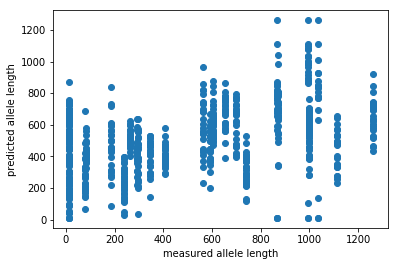

In [115]:
import time
start = time.time()
if not in_ipynb():
    example_workflow(name=gene_arg, tissue=tissue_arg, simulation_runs=simulation_arg, select_top_k_genes=top_genes_arg, PLSR_dimensions=PLSR_arg)
else:
    example_workflow(name="nakamori", tissue="muscle", simulation_runs=50, select_top_k_genes=500, PLSR_dimensions=2)
stop = time.time()
print("took {} seconds".format(stop - start))